## Intro 
In this notebook we will apply knowledge gathered from bacteria famillies analysis to KEGG pathways dataset, main difference between those we can expect is higher number of features and more highly corelated data.  

### Import libraries and load data

In [1]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN
from keras.layers import Dense, Dropout, Activation, Flatten
np.random.seed(111)
tf.random.set_seed(111)


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_KEGG_ortholog_merged.csv')


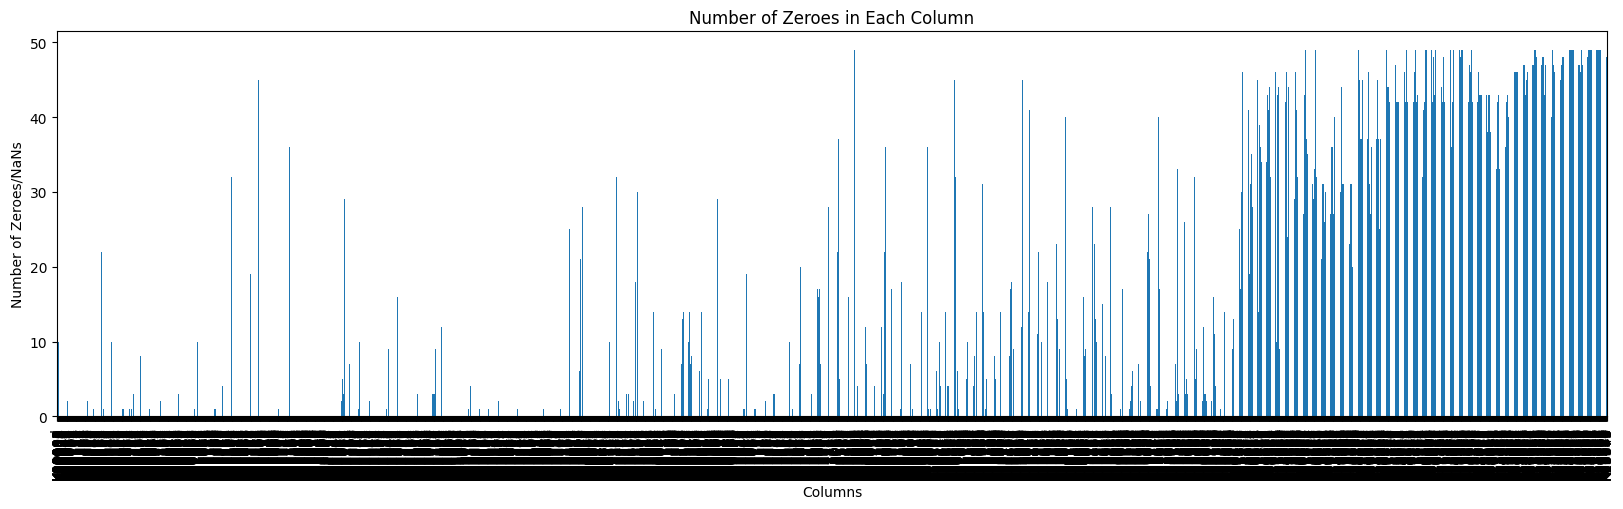

In [3]:
zero_counts = ((df == 0) | (df.isna())).sum()
zero_counts.plot(kind='bar', figsize=(20, 5))
plt.xlabel('Columns')
plt.ylabel('Number of Zeroes/NaNs')
plt.title('Number of Zeroes in Each Column')
plt.show()

Judnging from this not entirely beutifull plot we dont have that much missing observations this means that in sediment dataset which we have here most of the organisms lived in most of the ponds, we also have a big set of organisms that lived onyly in one kind of setup, This should give model enough information to classify.

In [4]:
print(df.shape)
df.head()

(50, 6369)


,pond,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,K00009,...,K19734,K19744,K03955,K06157,K07450,K07682,K12567,K15643,K16875,K18376
0,29,1111.21,26.0,2778.48,125.0,170.0,10.0,12.0,897.00,101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29,393.50,17.0,1221.01,31.0,145.0,0.0,0.0,448.00,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27,782.34,40.0,1608.34,56.5,135.0,65.0,13.0,771.83,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27,763.34,31.5,2032.50,80.5,187.5,0.0,8.0,717.67,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28,1039.50,34.5,2696.00,79.0,238.5,38.0,37.0,1065.33,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
predictors = df.columns[1:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"timepoint",  classes)

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()



number of predictors/bacteria famillies: 6368


,pond,timepoint,K00001,K00002,K00003,K00004,K00005,K00006,K00007,K00008,...,K19734,K19744,K03955,K06157,K07450,K07682,K12567,K15643,K16875,K18376
0,29,0,1111.21,26.0,2778.48,125.0,170.0,10.0,12.0,897.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29,1,393.50,17.0,1221.01,31.0,145.0,0.0,0.0,448.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27,0,782.34,40.0,1608.34,56.5,135.0,65.0,13.0,771.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27,1,763.34,31.5,2032.50,80.5,187.5,0.0,8.0,717.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28,0,1039.50,34.5,2696.00,79.0,238.5,38.0,37.0,1065.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

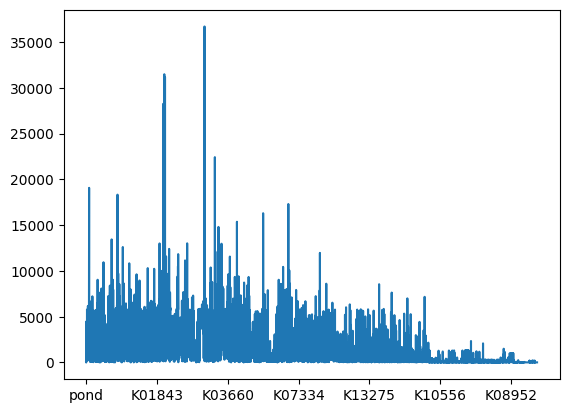

In [6]:
df.max().plot()

In [7]:
# for normalisation we will use starndard min-max normalisation
scaler = MinMaxScaler()
df[predictors] = scaler.fit_transform(df[predictors])




| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [8]:
df['pond_org'] = df['pond']

C:\Users\marek\AppData\Local\Temp\ipykernel_13796\3039816547.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pond_org'] = df['pond']


In [9]:
# Decoding use pond decoder 2 for this

codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

def pond_decoder_3(x, codes):
    num = int(x)
    for key, value_list in codes.items():
        if num in value_list:
            return key
    

df['pond']=df['pond_org'].apply(lambda x: pond_decoder_3(x, codes))


In [10]:
control_id = (df['timepoint'] == 0) | ((df['timepoint'] == 1) & (df['pond'] == 0))



In [11]:
df.loc[control_id, 'class'] = 0 
df.loc[df['class']!=0,'class'] = df.loc[df['class']!=0,'pond']

C:\Users\marek\AppData\Local\Temp\ipykernel_13796\3401523952.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[control_id, 'class'] = 0


In [12]:
# defragmenting 
df = df.copy()

In [13]:
#train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
#print(train_val_df.shape, test_df.shape)

### Definitions

In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [15]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

### Modelling without oversampling
We will start with made most sense form biological perspective: by using as controll all observations from tp 0 plus controll from tp 1. We will also use just dense neural networks and later we will move to Convolution.


In [64]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(1024,input_shape=(len(predictors),),activation='relu'))
model1.add(keras.layers.Dense(254, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))

model1.add(keras.layers.Dense(128, activation ='relu'))

model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dense(16, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(5, activation ='softmax'))

print(model1.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 1024)           │     6,521,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,824,499 (26.03 MB)

 Trainable params: 6,824,499 (26.03 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6000 - loss: 9.1908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
predicted classes:       [0 0 1 0 0 4 0 0 0 0]
true validation classes: [0 0 1 1 0 2 3 0 2 0]
mean confidence score: 12248491592.6647, sd confidence score: 36700395638.2647
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 1.3872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [0 0 0 0 0 0 0 0 0 0]
true validation classes: [3 0 4 3 0 1 0 0 3 0]
mean confidence score: 1.6257, sd confidence score: 0.0
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 4.7805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 3 0 2 0 0 0 0 0 0]
true validation classes: [2 0 0 1 4 0 0 0 1 4]
mean confidence score: 25587114043.4768, sd confidence score: 76754482741.7266
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4000 - loss:

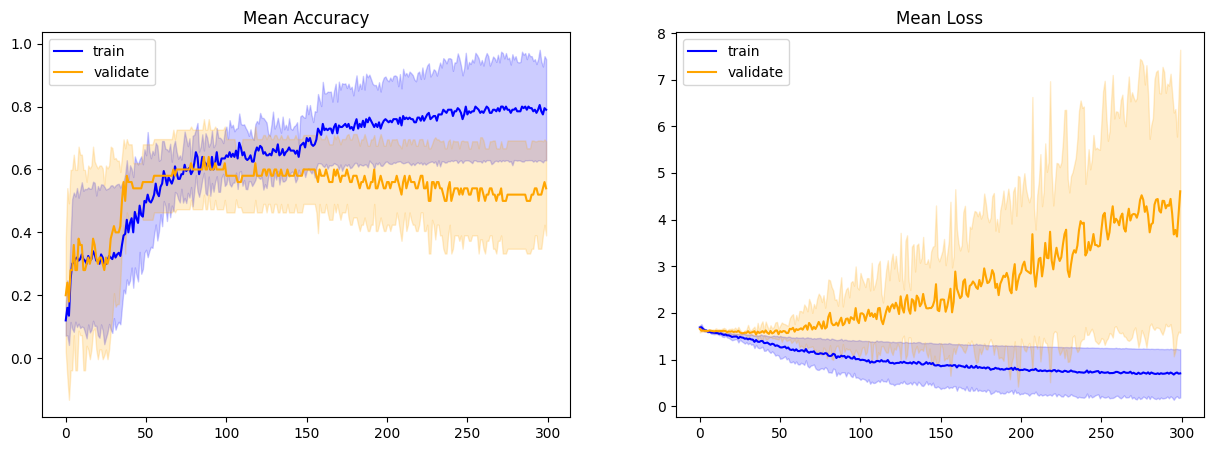

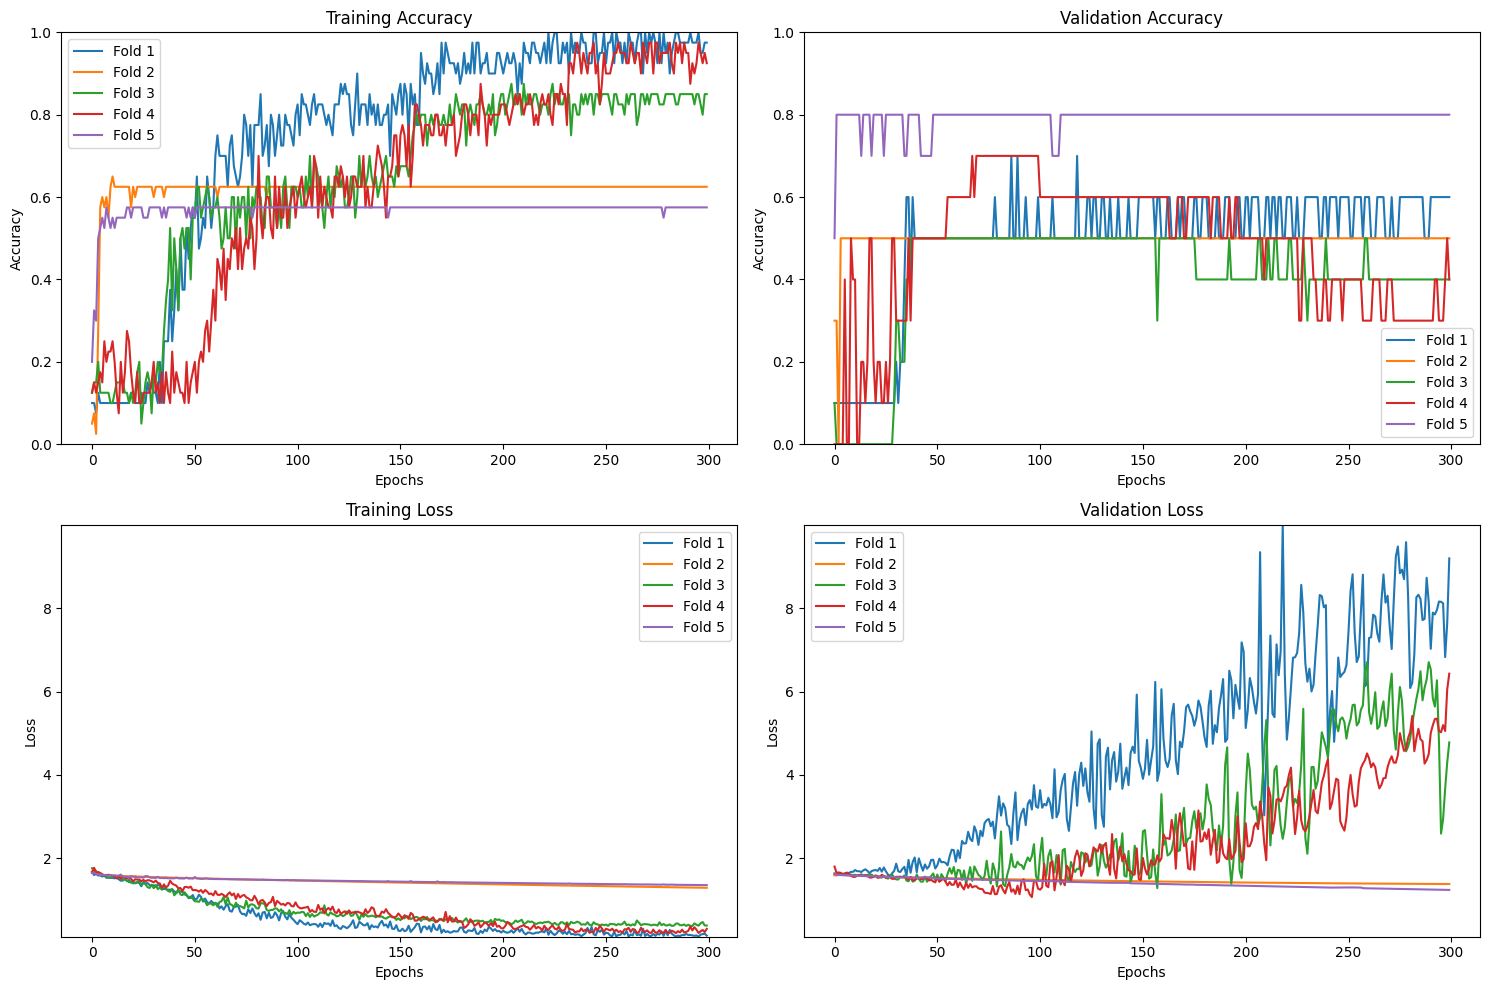

In [65]:
crossvalidate(df, model1, predictors, 'class', kf)

From the results we can note couple of things, Model can be much bigger than for previous datasets and still learn properly, this is because much more features = much more information. Model is not predicting evertyhing to overrepresented class, but its still acheving poor results. We Might fix that using oversampling or using convolutional approach.

### Convolution without oversampling 

In [17]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 6364, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6362, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12724)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │    13,030,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,333,081 (50.86 MB)

 Trainable params: 13,333,081 (50.86 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6000 - loss: 6.1949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
predicted classes:       [0 0 1 0 0 1 0 0 0 0]
true validation classes: [0 0 1 1 0 2 3 0 2 0]
mean confidence score: 539943245990.5281, sd confidence score: 1619829716936.1572
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4000 - loss: 6.6707
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted classes:       [2 0 0 0 0 0 1 0 0 0]
true validation classes: [3 0 4 3 0 1 0 0 3 0]
mean confidence score: 1136167504.2589, sd confidence score: 2561674791.7249
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3000 - loss: 2.9332
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
predicted classes:       [0 3 2 2 0 0 0 0 3 0]
true validation classes: [2 0 0 1 4 0 0 0 1 4]
mean confidence score: 289697461.6911, sd confidence score: 868499386.0709
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accu

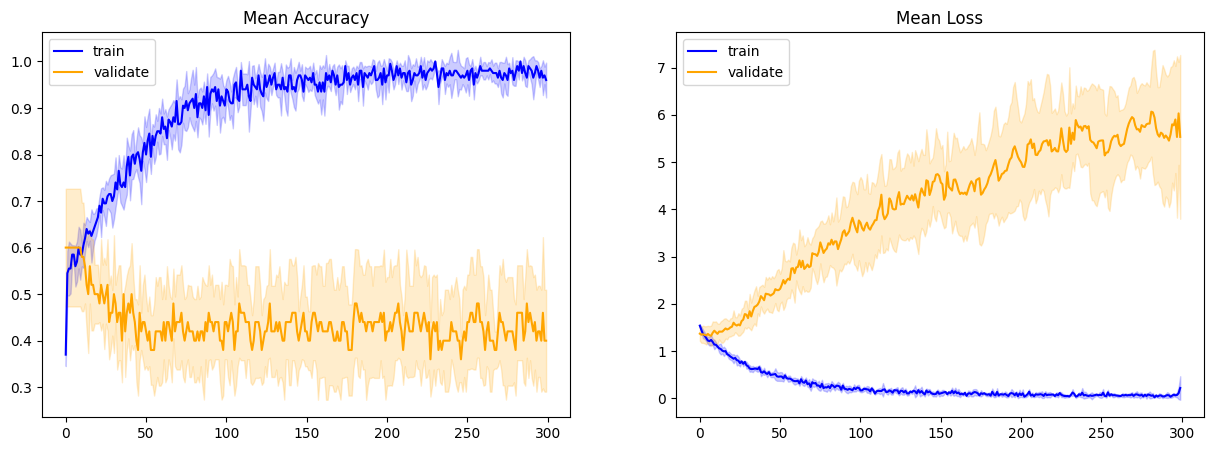

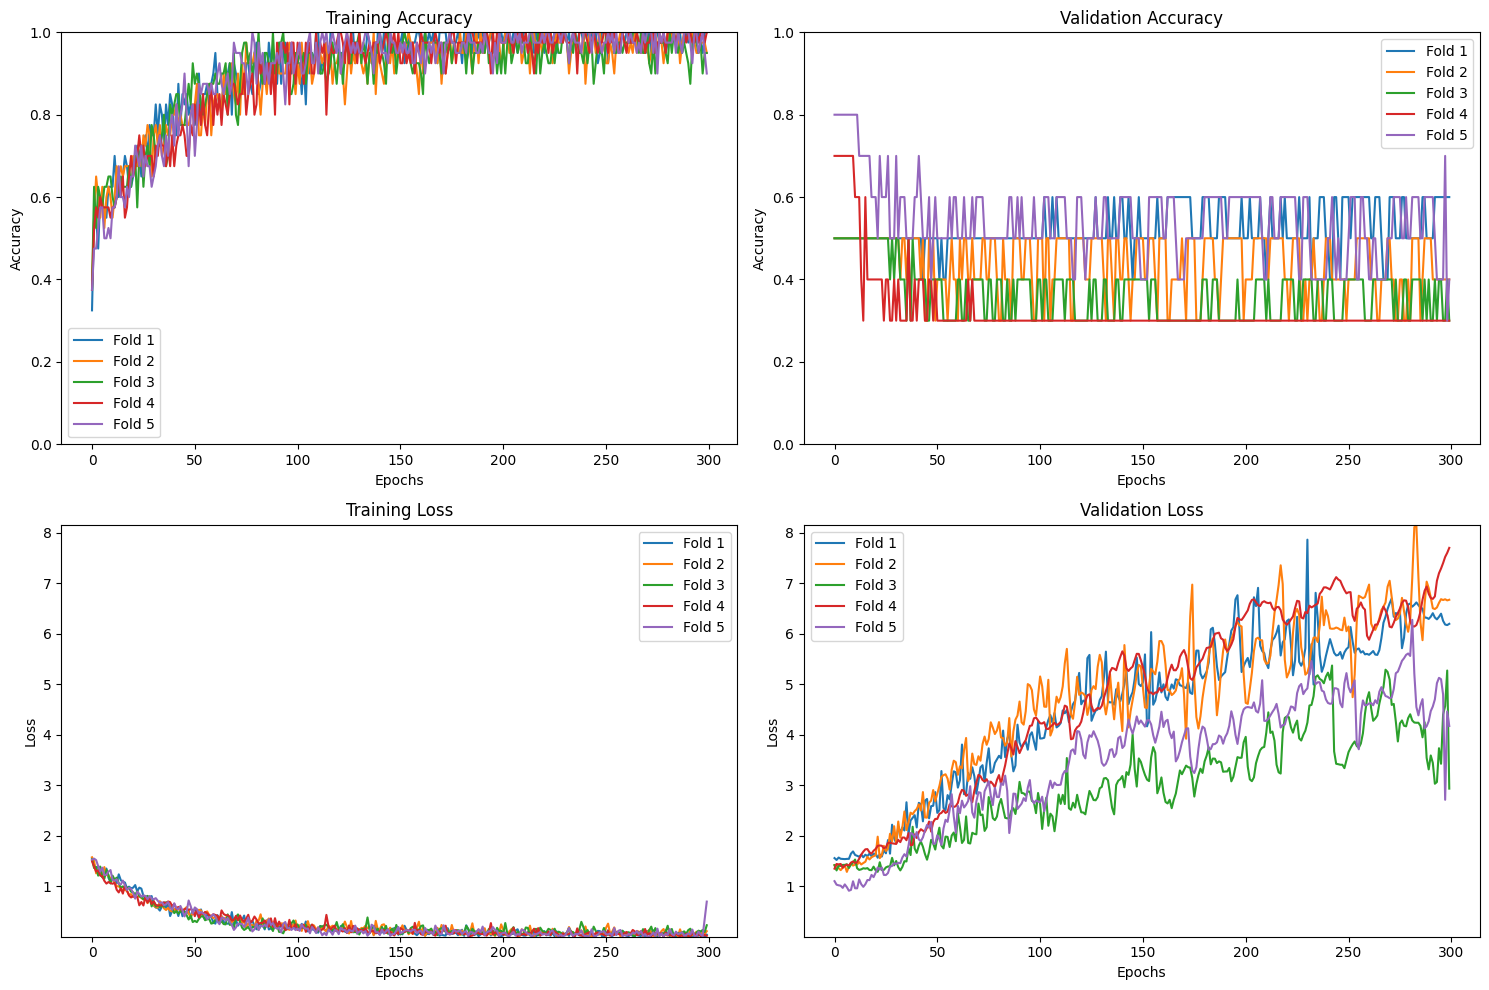

In [19]:
crossvalidate(df, model2, predictors, 'class', kf, True)

Convolutional approach seems to have similar results to dense, there is an option that convolution doesnt provide much learning and still learning is happening in dense layers after convolution. We will now check if the results from oversampled dataset will match each other.

### Oversampling 1:4 classes
For oversampling we will again use SMOTE algorythm as it is more sophisticated than just duplicating.

In [120]:
train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['class'])
train_val_df.shape, test_df.shape

((40, 241), (10, 241))

In [121]:
smote = SMOTE(random_state=111, sampling_strategy='not majority', k_neighbors=3)
X = train_val_df[predictors].values
y = train_val_df['class']

 

In [122]:
# Ensure y contains discrete class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_smote, y_smote = smote.fit_resample(X, y_encoded)

In [123]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

(40, 237) (40,)
(120, 237) (120,)


In [124]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['class'])], axis=1)
df_smote['class'].value_counts()

class
0    24
4    24
3    24
1    24
2    24
Name: count, dtype: int64

#### Modeling oversampled dataset

In [125]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 256)            │        60,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,501 (306.64 KB)

 Trainable params: 78,501 (306.64 KB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7917 - loss: 0.8217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted classes:       [0 4 1 1 1 1 4 4 0 0 1 1 1 2 3 3 3 3 3 3 3 4 4 4]
true validation classes: [0 4 3 1 1 0 0 0 0 0 0 1 1 2 3 3 3 3 3 3 3 4 4 4]
mean confidence score: 4.6217, sd confidence score: 3.0072
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9167 - loss: 0.7785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 2 3 3 0 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4]
true validation classes: [0 2 0 3 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3 3 4 4 4 4]
mean confidence score: 3.5094, sd confidence score: 2.6788
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.8860
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [2 3 4 2 1 1 1 1 2 2 2 2 3 3 3 3 3 4 2 0 4 2 4 4]
true validation classes: [0 3 0 2 0 1 1 1 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
mean confidence

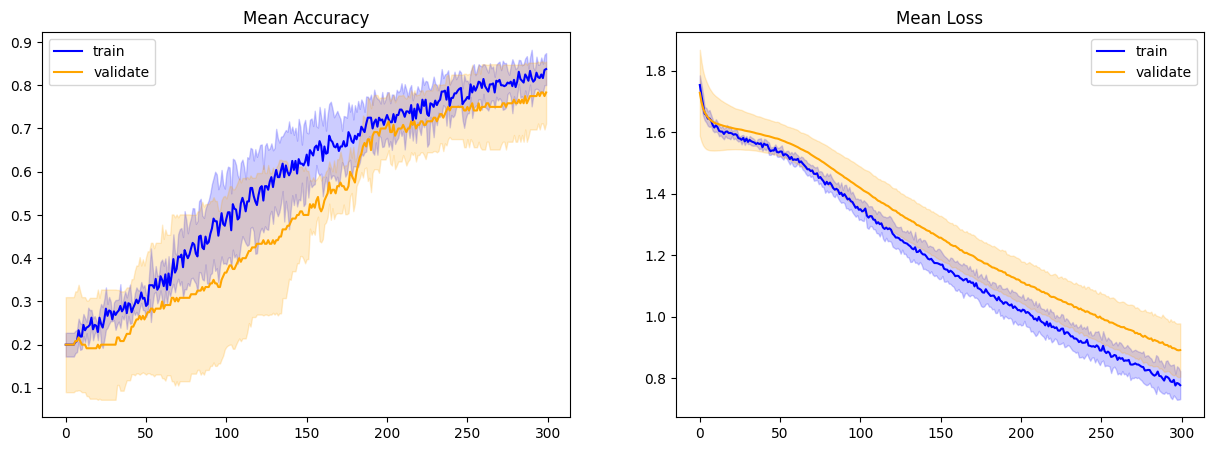

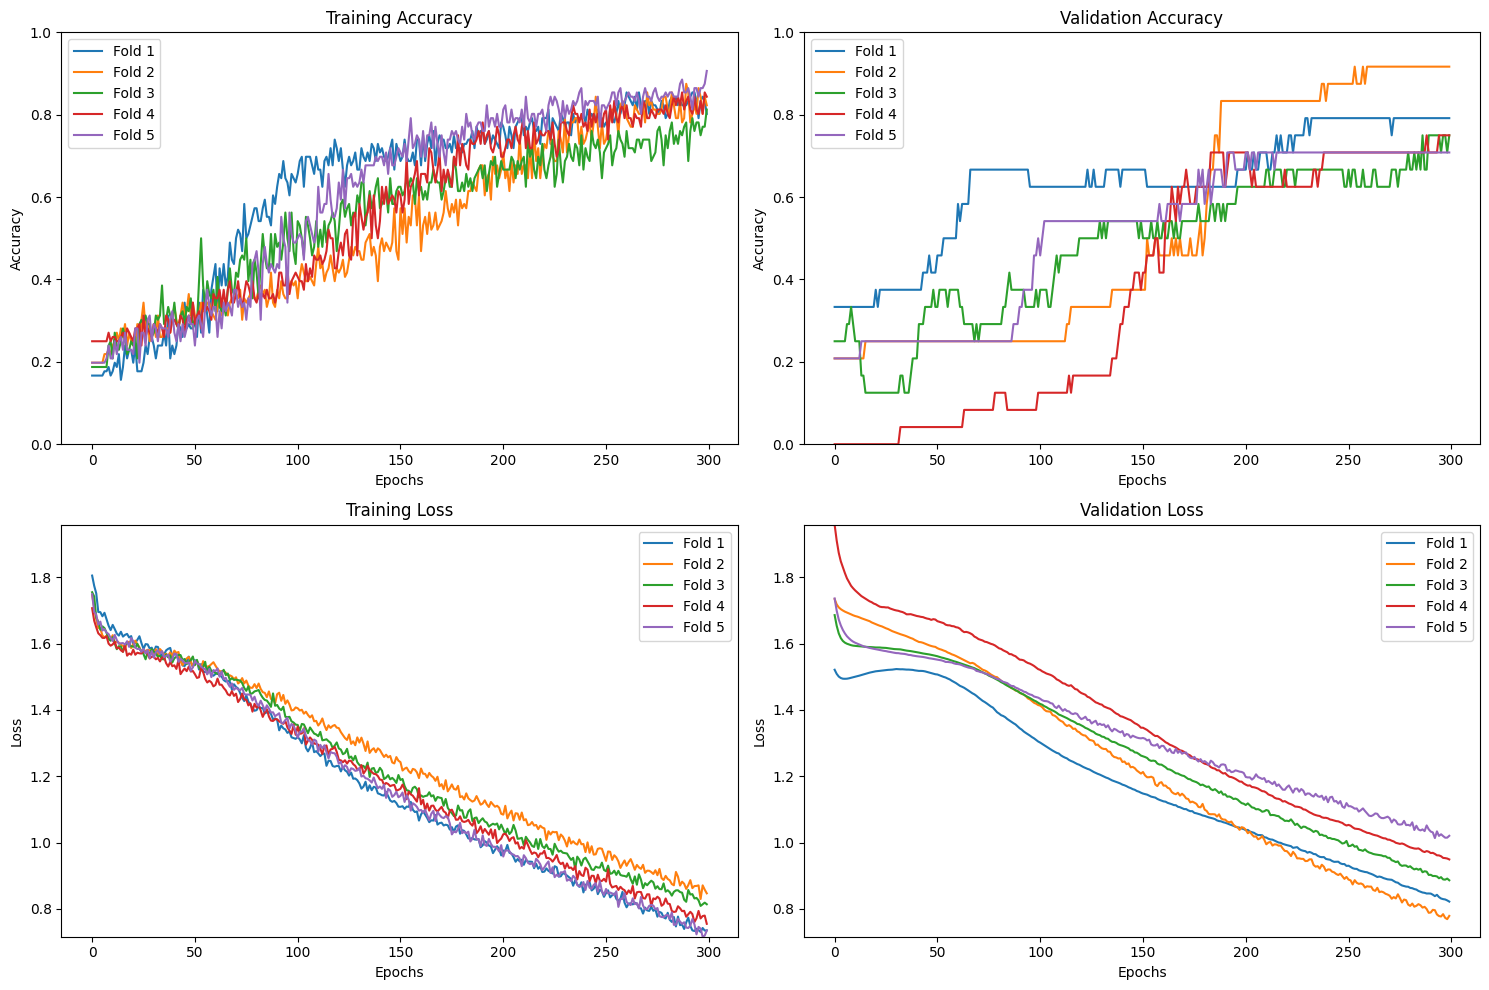

In [126]:
crossvalidate(df_smote, model2, predictors, 'class', kf)

As in bacteria dataset this approach is better than withour oversampling but we have to cosnider same problems as before, in addition accuracy is worse than for bacteria dataset, we will check resutls for test dataset now.

In [127]:
reset_weights(model2)
X_train_val = df_smote[predictors].values
y_train_val = keras.utils.to_categorical(df_smote['class'].values)
X_test = test_df[predictors].values
y_test = keras.utils.to_categorical(test_df['class'].values)
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape


((120, 237), (120, 5), (10, 237), (10, 5))

In [128]:
history2 = model2.fit(X_train_val, y_train_val, validation_data = (X_test, y_test), epochs=500, callbacks=[es_callback], verbose=1)


Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1602 - loss: 1.8248 - val_accuracy: 0.1000 - val_loss: 1.8528
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1602 - loss: 1.8028 - val_accuracy: 0.1000 - val_loss: 1.8351
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1602 - loss: 1.8043 - val_accuracy: 0.1000 - val_loss: 1.8212
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1602 - loss: 1.7873 - val_accuracy: 0.1000 - val_loss: 1.8061
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1602 - loss: 1.7938 - val_accuracy: 0.1000 - val_loss: 1.7901
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1602 - loss: 1.7651 - val_accuracy: 0.1000 - val_loss: 1.7732
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1602 - loss: 1.7509 - val_accuracy: 0.1000 - val_loss: 1.7558
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1602 - loss: 1.7631 - val_accuracy: 0.1000 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 1.5499
[1.5499203205108643, 0.20000000298023224]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted values: [0 3 3 0 0 3 3 3 0 0]
True values: [1 0 4 0 2 0 0 0 0 3]


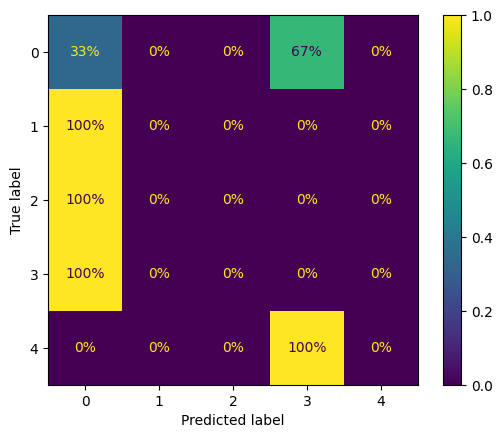

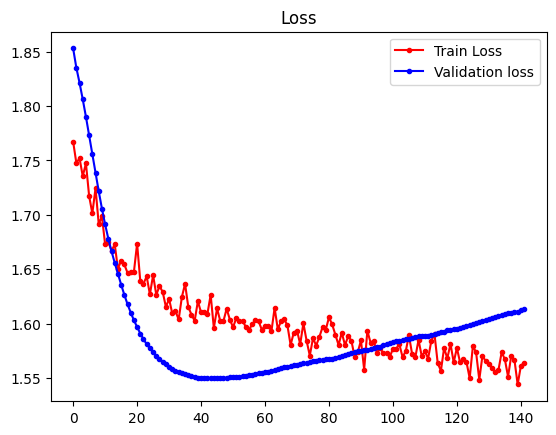

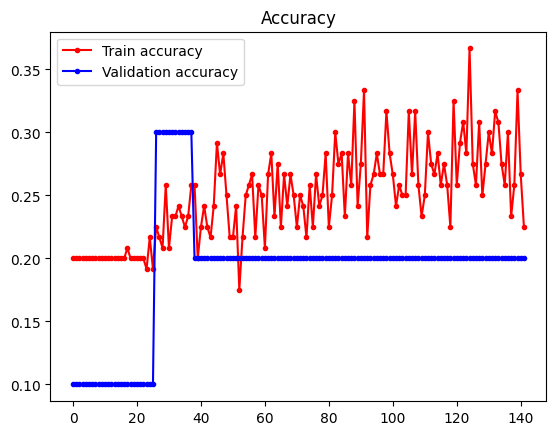

In [129]:
evaluate_model(model2,history2,test_df[predictors] , keras.utils.to_categorical(test_df['class']))

Here unfortunetelly we can see that model didnt learn anything and jsut predicted everything to class 0, the issue of overrepresentation was not present here, so the possible solution is that its much harder to make this kind of prediction based on KEGG dataset than on bacteria dataset. We will now move to best approach from previous analisis:

### Oversampling all of the classes in 5 class classification for both timepoints


In [131]:
train_val_df.shape, test_df.shape

((40, 241), (10, 241))

In [132]:
empty_class = pd.DataFrame(0, index=range(40),columns=train_val_df.columns)
#empty_class[] = np.random.rand(40, empty_class.shape[1])
empty_class['pond'] = 9


In [133]:
train_val_df_empty_class = pd.concat([train_val_df, empty_class], axis=0)

In [134]:
smote = SMOTE(random_state=111)
X = train_val_df_empty_class[predictors].values
y = train_val_df_empty_class['pond']

In [135]:
X.shape, y.shape

((80, 237), (80,))

In [136]:
X_smote, y_smote = smote.fit_resample(X, y)
y_smote.shape

(240,)

In [137]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)
df_smote_cleared = df_smote[df_smote['pond'] != 9]
df_smote_cleared.reset_index(drop=True, inplace=True)
print(df_smote_cleared.shape)
df_smote_cleared['pond'].value_counts()

(200, 238)


pond
1    40
0    40
4    40
3    40
2    40
Name: count, dtype: int64

(80, 237) (80,)
(240, 237) (240,)
Number of classes: 5
training for 1 subset


C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8375 - loss: 0.5940  
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026FA6EA7380> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
predicted classes:       [1 0 4 2 4 1 1 0 3 0 0 0 0 1 0 0 1 1 1 1 1 3 2 2 2 2 2 2 1 3 3 1 3 4 4 4 4
 4 4 4]
true validation c

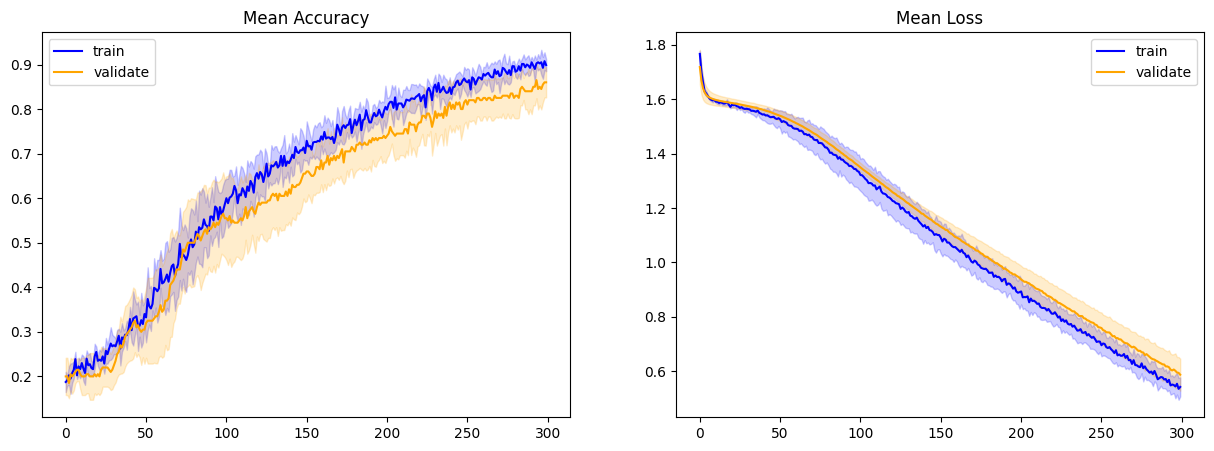

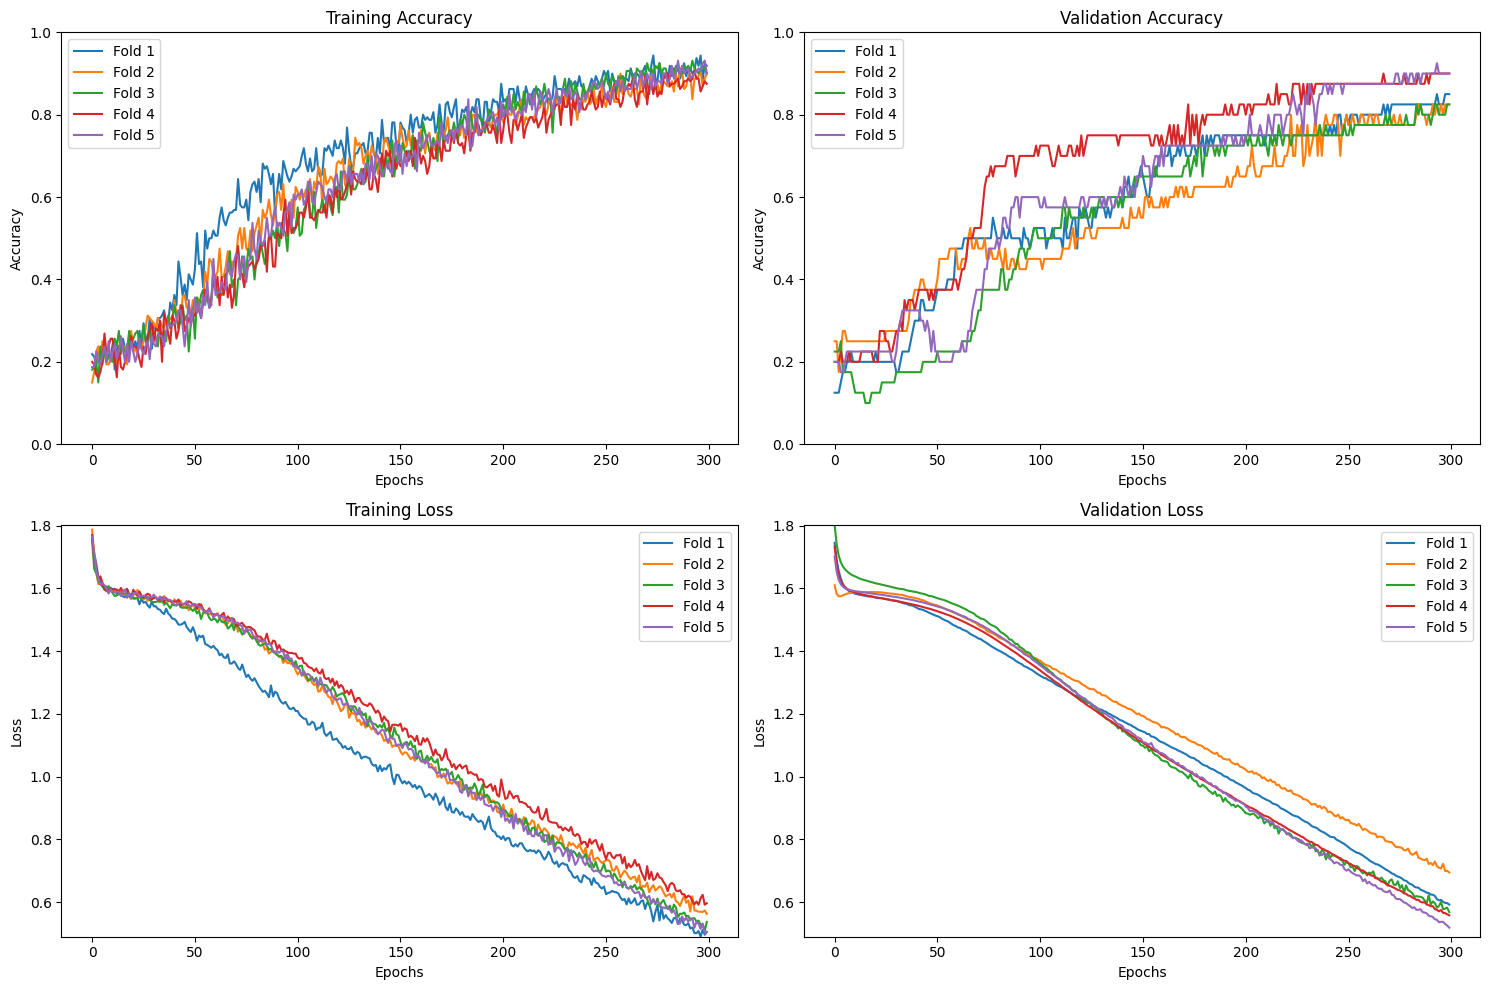

In [138]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

model3 = keras.Sequential()
model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='sigmoid'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='sigmoid'))
model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)
crossvalidate(df_smote_cleared, model3, predictors, 'pond', kf)

In [139]:
X = df_smote_cleared[predictors].values
y = keras.utils.to_categorical(df_smote_cleared['pond'].values)
y_test = keras.utils.to_categorical(test_df['pond'].values)
X_test = test_df[predictors].values
reset_weights(model3)   

history5 = model3.fit(X, y, epochs=300, batch_size=5,validation_data=(X_test, y_test), verbose=1, callbacks=[es_callback])

Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1658 - loss: 1.7993 - val_accuracy: 0.1000 - val_loss: 1.8599
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2035 - loss: 1.6961 - val_accuracy: 0.1000 - val_loss: 1.7841
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1856 - loss: 1.6511 - val_accuracy: 0.0000e+00 - val_loss: 1.7446
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2343 - loss: 1.6079 - val_accuracy: 0.1000 - val_loss: 1.7233
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1826 - loss: 1.6096 - val_accuracy: 0.1000 - val_loss: 1.7096
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2092 - loss: 1.6077 - val_accuracy: 0.1000 - val_loss: 1.6990
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2844 - loss: 1.5854 - val_accuracy: 0.1000 - val_loss: 1.6911
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2590 - loss: 1.5938 - val_accuracy: 0.1000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1000 - loss: 1.8599
[1.8598884344100952, 0.10000000149011612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted values: [3 3 3 3 3 3 3 3 3 3]
True values: [1 2 4 0 2 0 0 2 1 3]


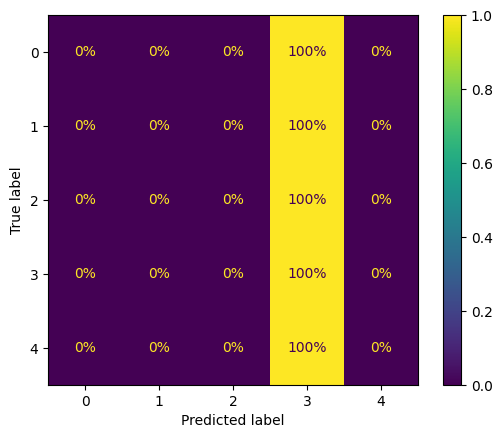

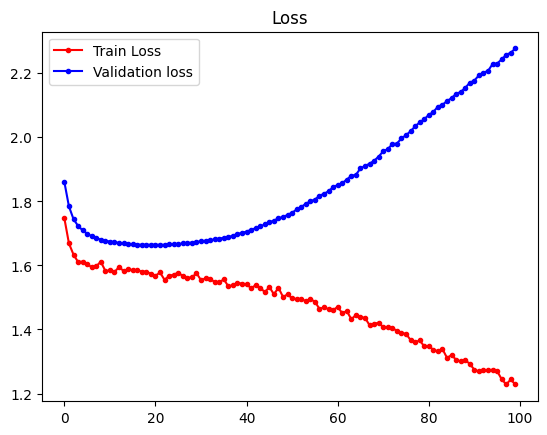

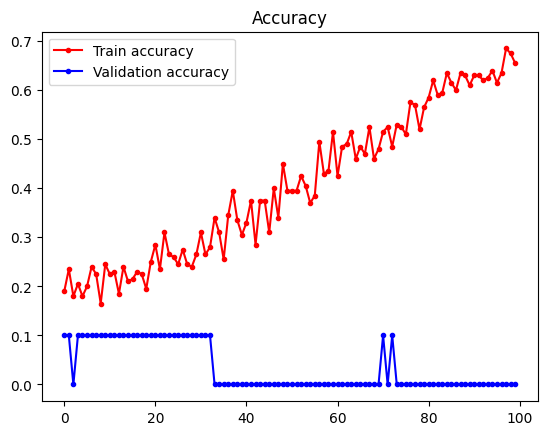

In [140]:
evaluate_model(model3, history5, X_test, y_test)

We can see simillar issues to previous classification approach, model is behaving much worse than for batcteria dataset. So if we are using same architecture results for KEGG paths dataset are much worse in comparison to bacteria dataset. Again issue of small number of original samples is probably causing most of the problems but we can see that model is having much harder time with KEGG dataset.